In [154]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
%matplotlib inline

In [21]:
data = pd.read_csv('data/round_train.csv')
data1 = pd.read_csv('data/round_test.csv',header=None)
data1.columns = data.columns
data = pd.concat([data,data1])

In [4]:
data = data[data.Tournament_Year.isin([2003,2004])]

In [22]:
data.shape

(231125, 12)

In [23]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [24]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [25]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [26]:
rounds = data.groupby(['Tournament_Year','Tournament_#','Round_Number'])

In [27]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)

In [155]:
print n_players,n_rounds

2461 2263


In [29]:
def alpha(A,a):
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [30]:
(n_players*(n_rounds/60+1))**2 * 10 / 1.0e9

87.45616324

In [31]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [189]:
A = csc_matrix(np.array([[3,4],[2,1]]))
B = csc_matrix(np.array([[5,4],[1,-1]]))

In [199]:
bmat([[A]])

<2x2 sparse matrix of type '<type 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Column format>

In [202]:
# def inflate(round_group,bin_size,BETA):
#     mats = []
#     mats_1 = []
#     n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
#     mat = csc_matrix((n_players*n_round_groups,n_players),dtype=float)
#     mat_1 = csc_matrix((n_players*n_round_groups,n_players),dtype=float)
#     for j in range(bin_size):
#         mat += bmat([[load_sparse_csc('rounds/%d.npz' % (round_group*j))*BETA**abs(round_group-k)] for k in range(1,n_round_groups+1)],format='csc')
#         mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % (round_group*j))!=0).astype(float)*BETA**abs(round_group-k)] for k in range(1,n_round_groups+1)],format='csc')
#     inflate.__dict__[round_group] = (mat,mat_1)
#     out_mat = bmat([[inflate.__dict__[i][0][0:n_players*round_group] for i in range(1,round_group+1)]],format='csc')
#     out_mat1 = bmat([[inflate.__dict__[i][1][0:n_players*round_group] for i in range(1,round_group+1)]],format='csc')
#     return (out_mat,out_mat1)


def inflate(round_group,bin_size,BETA):
    mats = []
    mats_1 = []
    n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
    for i in range(1,round_group+1):
        mat = csc_matrix((n_players*round_group,n_players),dtype=float)
        mat_1 = csc_matrix((n_players*round_group,n_players),dtype=float)
        for j in range(bin_size):
            mat += bmat([[load_sparse_csc('rounds/%d.npz' % (i*j))*BETA**abs(i-k)] for k in range(1,round_group+1)],format='csc')
            mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % (i*j))!=0).astype(float)*BETA**abs(i-k)] for k in range(1,round_group+1)],format='csc')
        mats.append(mat)
        mats_1.append(mat_1)
    return bmat([mats],format='csc'),bmat([mats_1],format='csc')

In [203]:
def solve(mat,mat_1,a,x_guess=None,x_guess1=None):
    S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    solve.w_a = w_a
    
    S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    solve.w_g = w_g
    
    return (w_a/w_g)[-n_players:]

# def solve2(mat,mat_1,a):
#     S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
#     w_a = inv(S).dot(mat.sum(1)).A1
    
#     S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1
#     w_g = inv(S).dot(mat_1.sum(1)).A1
    
#     return w_a/w_g

In [204]:
ranks = []
BETA = .85
a = .8
bin_size = 30
n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
current_group = 0
tournaments=[set()]
for round_ind,df in enumerate(rounds):
    df = df[1]
    round_group = round_ind/bin_size
    if round_group>22:
        continue
    if round_group>current_group:
        A,G = inflate(round_group,bin_size,BETA)
        if current_group==0:
            ranks.append(solve(A,G,a))
            print 'Round Group %d done' % current_group
            current_group = round_group
            tournaments.append(set())
        else:
            w_a_approx = np.append(solve.w_a,solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g,solve.w_g[-n_players:])
            ranks.append(solve(A,G,a,w_a_approx,w_g_approx))
            print 'Round Group %d done' % current_group
            current_group = round_group
            tournaments.append(set())
    tournaments[current_group].update([df.iloc[0]['Permanent_Tournament_#']])

Round Group 0 done
Round Group 1 done
Round Group 2 done
Round Group 3 done
Round Group 4 done
Round Group 5 done
Round Group 6 done
Round Group 7 done
Round Group 8 done
Round Group 9 done
Round Group 10 done
Round Group 11 done
Round Group 12 done
Round Group 13 done
Round Group 14 done
Round Group 15 done
Round Group 16 done
Round Group 17 done
Round Group 18 done
Round Group 19 done
Round Group 20 done
Round Group 21 done


In [118]:
with open('example.txt','w') as f:
    for l in zip(csc_matrix(G[0:3,0:3]).data,zip(*[i.tolist() for i in csc_matrix(G[0:3,0:3]).nonzero()])):
        f.write(','.join(map(str,[l[0],l[1][0],l[1][1]])))
        f.write('\n')

In [69]:
save_sparse_csc('example',csc_matrix(G))

In [205]:
for i in range(1,len(tournaments)):
    tournaments[i] = tournaments[i]-tournaments[i-1]

In [206]:
tournaments

[{1, 2, 3, 4, 5, 6, 7, 16},
 {8, 9, 10, 11, 12, 14, 22},
 {18, 19, 20, 21, 23, 24, 26, 480},
 {25, 27, 28, 29, 34, 37, 100},
 {30, 32, 33, 35, 472, 474, 476, 505},
 {13, 41, 45, 47, 54, 473, 475},
 {2, 3, 4, 5, 6, 16, 60},
 {1, 7, 8, 9, 10, 11, 14, 22},
 {12, 18, 19, 20, 21, 25, 480},
 {23, 24, 26, 27, 28, 30, 37, 100},
 {29, 33, 34, 35, 472, 476, 505},
 {13, 32, 41, 45, 47, 54, 473, 474},
 {2, 3, 4, 6, 16, 60, 475},
 {1, 5, 7, 8, 9, 10, 11, 22},
 {12, 14, 18, 19, 20, 21, 25, 480},
 {23, 24, 26, 27, 28, 30, 37},
 {29, 33, 34, 35, 100, 472, 476, 505},
 {13, 32, 41, 45, 47, 473, 474},
 {2, 4, 6, 16, 54, 60, 475},
 {1, 3, 5, 7, 8, 9, 10, 11},
 {12, 14, 18, 19, 20, 22, 480},
 {21, 23, 24, 25, 26, 27, 28, 34},
 {29, 30, 33, 35, 37, 100, 472}]

In [207]:
ols = LinearRegression()
iso = IsotonicRegression(increasing=False)

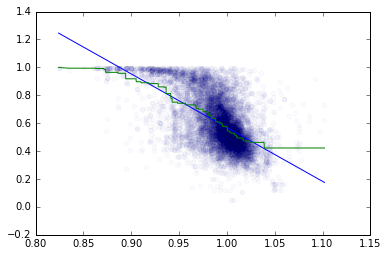

In [210]:
ratings,outcomes = [],[]
for t_ind in range(1,len(tournaments)):
    sub = data[data['Permanent_Tournament_#'].isin(tournaments[t_ind])]
    df1 = pd.DataFrame(sub.groupby('Player_Index')['Finishing_Pct'].mean())
    df2 = pd.DataFrame(ranks[t_ind-1],columns=['rating'])
    df = df1.merge(df2,left_index=True,right_index=True).dropna()
    ratings += df.rating.values.tolist()
    outcomes += df.Finishing_Pct.values.tolist()
ratings,outcomes = np.array(ratings),np.array(outcomes)
ols.fit(ratings[:,None],outcomes)
iso.fit(ratings,outcomes)
predictions_o = ols.predict(np.sort(ratings)[:,None])
predictions_i = iso.predict(np.sort(ratings))
plt.scatter(ratings,outcomes,alpha=.02)
plt.plot(np.sort(ratings),predictions_o)
plt.plot(np.sort(ratings),predictions_i)
plt.show()

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


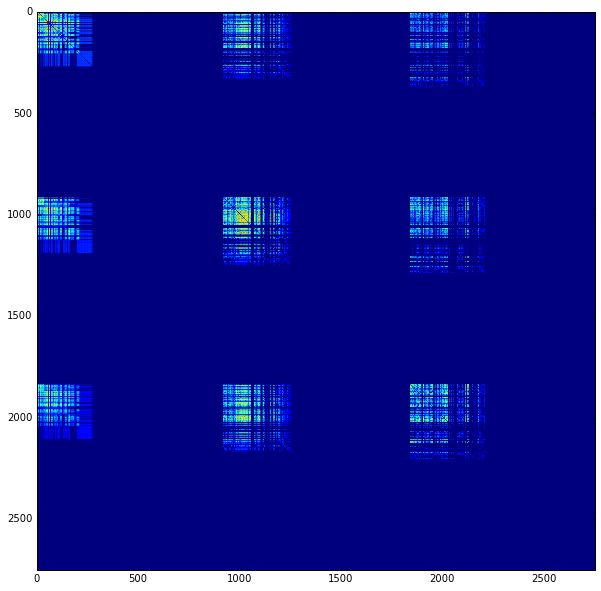

In [106]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A_.toarray());

In [116]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [215]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[0][-n_players:]}).sort_values('rank',ascending=False)

,player_ind,player_name,rank
12,12,"Els, Ernie",1.064572
277,277,"Woods, Tiger",1.054180
180,180,"Weir, Mike",1.052314
5,5,"Price, Nick",1.046068
27,27,"Goosen, Retief",1.042702
309,309,"Barnes, Ricky",1.039788
80,80,"Pride, Dicky",1.038292
198,198,"Love III, Davis",1.037297
13,13,"Singh, Vijay",1.036344
296,296,"Fasth, Niclas",1.035564


In [146]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [147]:
inds_to_plot = [names_to_ind['Woods, Tiger'],names_to_ind['Singh, Vijay']]

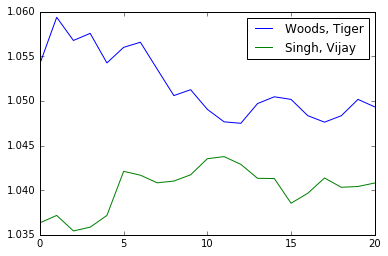

In [214]:
for j in inds_to_plot:
    plt.plot([ranks[i][j] for i in range(21)],label = inds_to_name[j]);
plt.legend();

# for i in [0,1]:
#     plt.plot(with_8[i])
#     plt.plot(with_9[i]);